In [1]:
#!pip install pyshp
# !pip install geopy

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()
user_agent = os.getenv('user_agent')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shapefile as shp
from  shapely.geometry import Point, Polygon
import geopandas as gpd
import seaborn as sns
import geopy
from geopy import geocoders, distance
%matplotlib inline

In [4]:
# load the train data.
wnv_raw_train = pd.read_csv("../data/train.csv")

# load the weather data.
wnv_raw_weather = pd.read_csv("../data/weather.csv")

In [5]:
# explore train data.
print ("shape of train dataset (row, col) =",wnv_raw_train.shape)
wnv_raw_train.info()

shape of train dataset (row, col) = (10506, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    10506 non-null  object 
 1   Address                 10506 non-null  object 
 2   Species                 10506 non-null  object 
 3   Block                   10506 non-null  int64  
 4   Street                  10506 non-null  object 
 5   Trap                    10506 non-null  object 
 6   AddressNumberAndStreet  10506 non-null  object 
 7   Latitude                10506 non-null  float64
 8   Longitude               10506 non-null  float64
 9   AddressAccuracy         10506 non-null  int64  
 10  NumMosquitos            10506 non-null  int64  
 11  WnvPresent              10506 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 985.1+ KB


There does not seem  to be any missing value. Our target variable = WnvPresent

In [6]:
wnv_raw_train.describe()

,Block,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
count,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000
mean,35.687797,41.841139,-87.699908,7.819532,12.853512,0.052446
std,24.339468,0.112742,0.096514,1.452921,16.133816,0.222936
min,10.000000,41.644612,-87.930995,3.000000,1.000000,0.000000
25%,12.000000,41.732984,-87.760070,8.000000,2.000000,0.000000
50%,33.000000,41.846283,-87.694991,8.000000,5.000000,0.000000
75%,52.000000,41.954690,-87.627796,9.000000,17.000000,0.000000
max,98.000000,42.017430,-87.531635,9.000000,50.000000,1.000000


## Explore the colums.

In [7]:
wnv_raw_train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [8]:
# convert the data type of date column from object to date.
wnv_raw_train["Date"] = pd.to_datetime(wnv_raw_train["Date"])
# add new column year-mm.
# we could use it to compare yearly, monthly change across the dataset.
wnv_raw_train["year-mm"] = pd.DatetimeIndex(wnv_raw_train["Date"]).to_period("M")
wnv_raw_train["year"] = pd.DatetimeIndex(wnv_raw_train["Date"]).year
wnv_raw_train["month"] = pd.DatetimeIndex(wnv_raw_train["Date"]).month

# add a column - zip codes
wnv_raw_train["zip_code"] =wnv_raw_train.Address.str.extract(r'(\d{5}\-?\d{0,4})')

# get the column names.
obj_col_nms = wnv_raw_train.select_dtypes(include="object").columns
not_obj_col_nms = wnv_raw_train.select_dtypes(exclude=["object", "datetime64"]).columns

print (obj_col_nms)
print (not_obj_col_nms)


Index(['Address', 'Species', 'Street', 'Trap', 'AddressNumberAndStreet',
       'zip_code'],
      dtype='object')
Index(['Block', 'Latitude', 'Longitude', 'AddressAccuracy', 'NumMosquitos',
       'WnvPresent', 'year-mm', 'year', 'month'],
      dtype='object')


,Virus Count,Virus
0,9955,Virus Absent
1,551,Virus Present


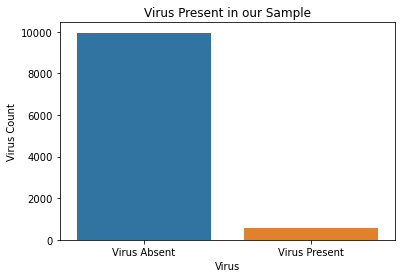

In [9]:
col_nms = ["year",'WnvPresent', 'Species', 'Trap', 'NumMosquitos' ]
df_virus = pd.DataFrame(["Virus Absent", "Virus Present"],wnv_raw_train["WnvPresent"].value_counts())
df_virus = df_virus.reset_index()
df_virus.columns = ["Virus Count", "Virus"]
sns.barplot(data=df_virus, x="Virus", y="Virus Count")
plt.title("Virus Present in our Sample")
df_virus

Maximum # of data in the dataset does not contain virus. This is an imbalance. Can we balance it ?

Text(0.5, 1.0, 'Virus Carrier Species')

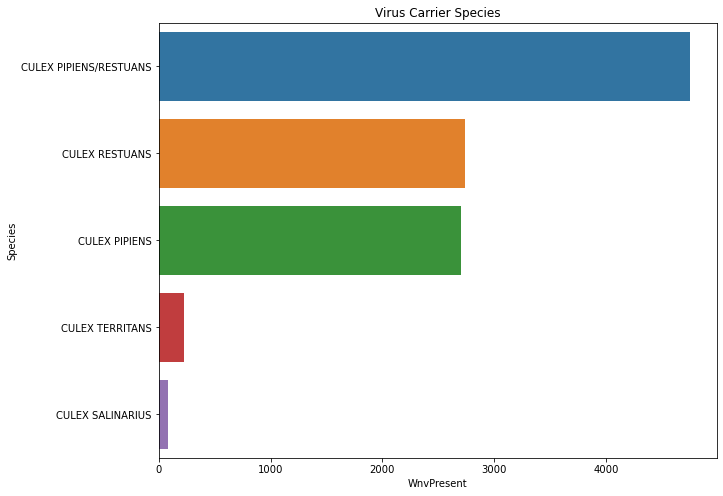

In [10]:
_ = plt.subplots(figsize=(10,8))
species_virus = pd.DataFrame(wnv_raw_train[["Species", "WnvPresent"]].groupby(["Species"])["WnvPresent"].count().nlargest()).reset_index()
sns.barplot(data=species_virus, x="WnvPresent", y="Species", orient="h")
plt.title("Virus Carrier Species")

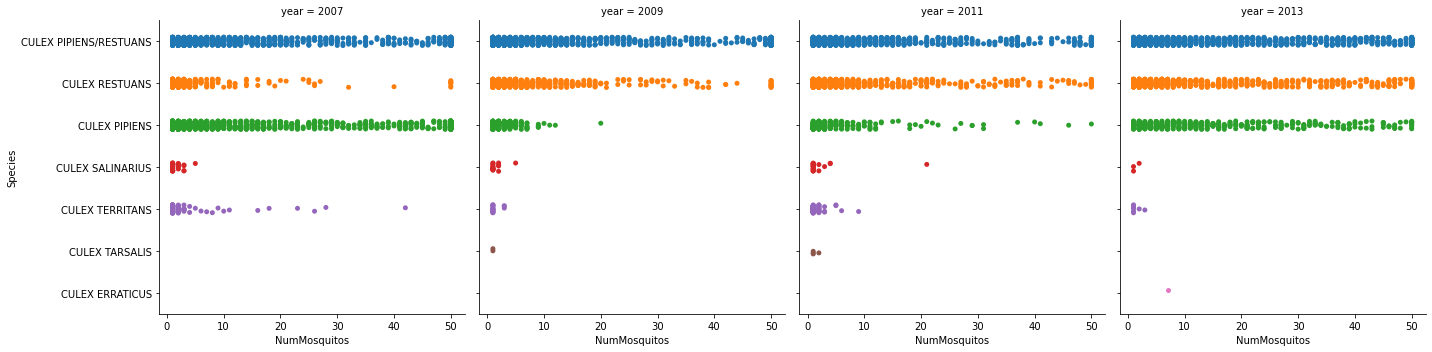

In [11]:

sns.catplot(data=wnv_raw_train, x="NumMosquitos", y="Species", orient="h", col="year")

In [12]:
# Top 3 and map other species to "Others"
other_species = {'CULEX TERRITANS':"CLUEX-OTHERS",'CULEX SALINARIUS':"CLUEX-OTHERS",'CULEX TARSALIS':"CLUEX-OTHERS",'CULEX ERRATICUS':"CLUEX-OTHERS"}
wnv_raw_train["Species"]= wnv_raw_train["Species"].replace(other_species)

    Block  Species  Trap  NumMosquitos  WnvPresent
0      10        4  1722         31852         111
1      12        4   605         21789          41
2      11        4   736          8669          26
3      70        4   295          4637          16
4      22        4   500          4254          29
5      42        4   300          3845          16
6      41        4   185          3710          18
7      37        4   330          3597           7
8      52        4   277          3327          16
9      24        4   160          3315          11
10     35        4   229          3198           7
11     13        4   345          3190          11
12     50        4   244          2435          13
13     61        4   228          2210          14
14     58        4   252          2207          20
15     17        4   305          2171          11
16     82        4   120          2143          12
17     40        4   189          1989          13
18     91        4   111       

[Text(0, 0, '10'),
 Text(1, 0, '11'),
 Text(2, 0, '12'),
 Text(3, 0, '13'),
 Text(4, 0, '14'),
 Text(5, 0, '15'),
 Text(6, 0, '17'),
 Text(7, 0, '18'),
 Text(8, 0, '20'),
 Text(9, 0, '21'),
 Text(10, 0, '22'),
 Text(11, 0, '24'),
 Text(12, 0, '25'),
 Text(13, 0, '27'),
 Text(14, 0, '28'),
 Text(15, 0, '29'),
 Text(16, 0, '30'),
 Text(17, 0, '33'),
 Text(18, 0, '34'),
 Text(19, 0, '35'),
 Text(20, 0, '36'),
 Text(21, 0, '37'),
 Text(22, 0, '38'),
 Text(23, 0, '39'),
 Text(24, 0, '40'),
 Text(25, 0, '41'),
 Text(26, 0, '42'),
 Text(27, 0, '43'),
 Text(28, 0, '45'),
 Text(29, 0, '46'),
 Text(30, 0, '47'),
 Text(31, 0, '48'),
 Text(32, 0, '49'),
 Text(33, 0, '50'),
 Text(34, 0, '51'),
 Text(35, 0, '52'),
 Text(36, 0, '53'),
 Text(37, 0, '55'),
 Text(38, 0, '58'),
 Text(39, 0, '60'),
 Text(40, 0, '61'),
 Text(41, 0, '62'),
 Text(42, 0, '63'),
 Text(43, 0, '64'),
 Text(44, 0, '65'),
 Text(45, 0, '66'),
 Text(46, 0, '67'),
 Text(47, 0, '68'),
 Text(48, 0, '70'),
 Text(49, 0, '71'),
 Text(50, 

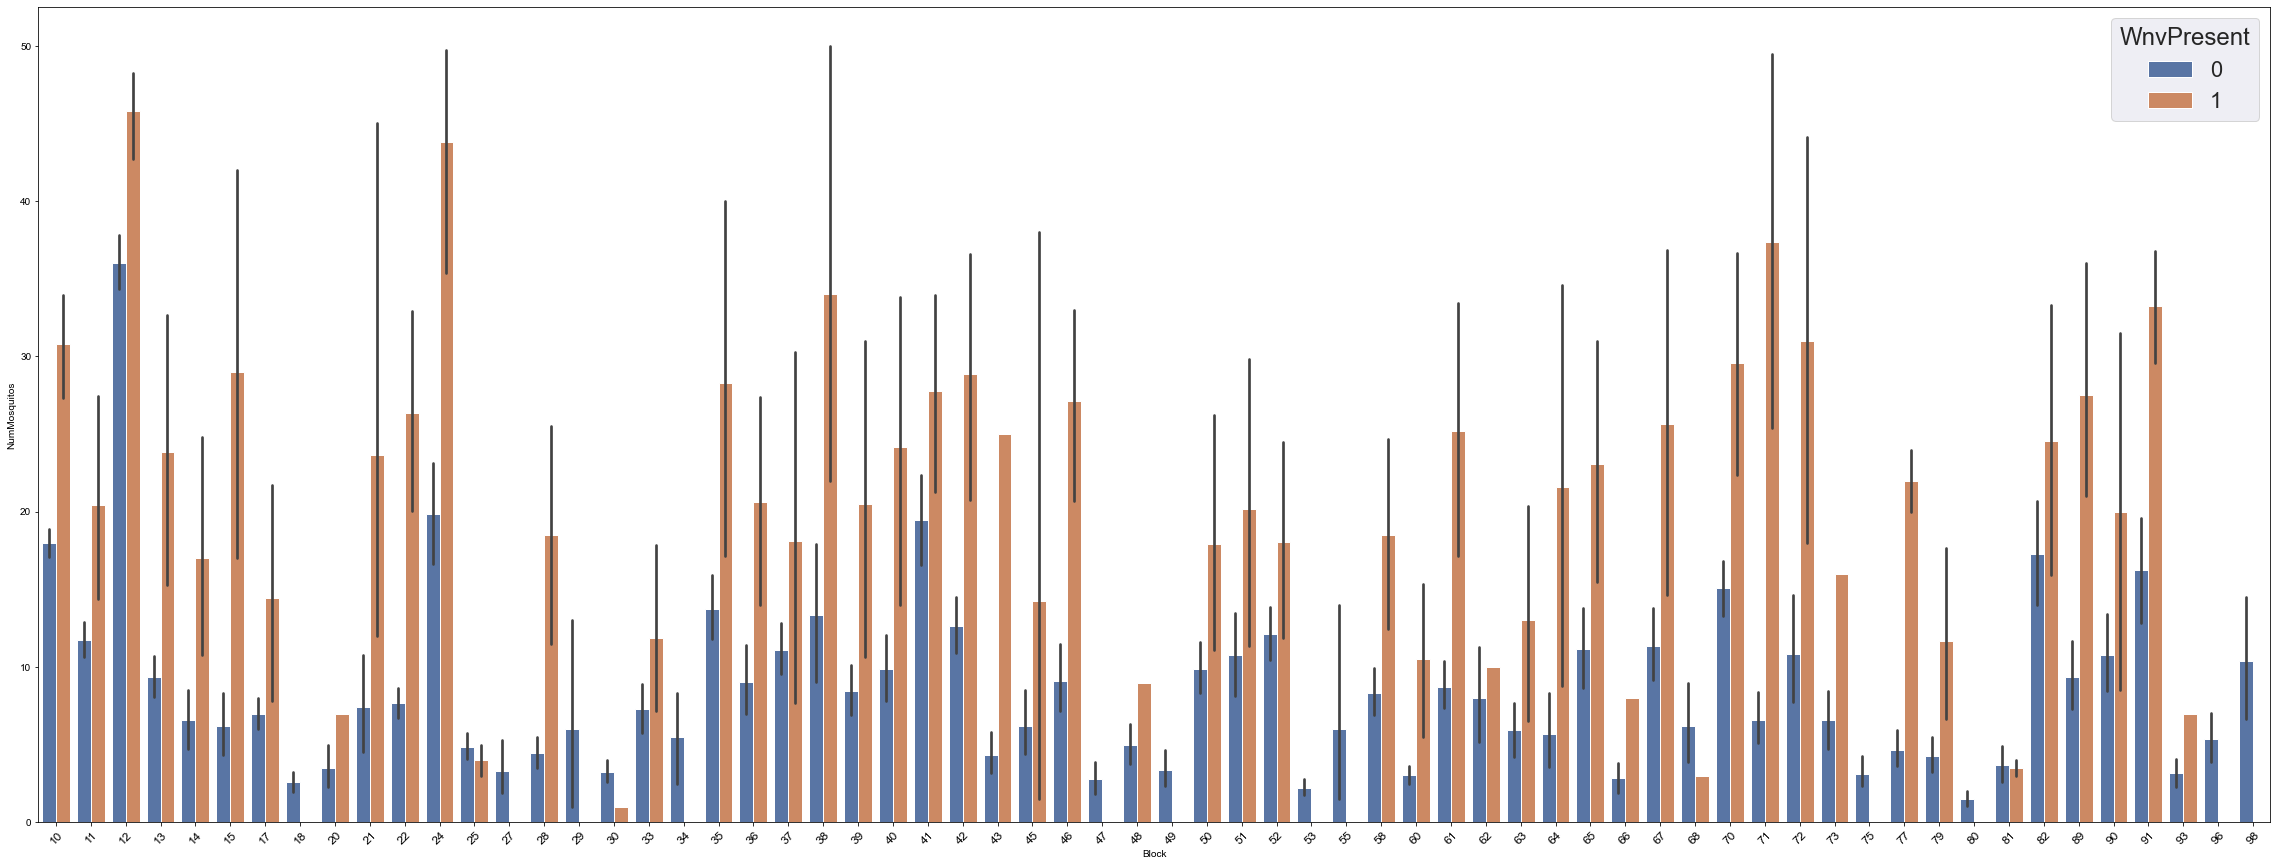

In [13]:
block_species_mos_count = \
    wnv_raw_train.groupby(["Block"], sort=True)[col_nms].agg({"Species":"nunique", "Trap":"count", "NumMosquitos":"sum", "WnvPresent":"sum"})\
        .nlargest(columns=["NumMosquitos", "WnvPresent"],n=30).reset_index()

print (block_species_mos_count)

fig, ax= plt.subplots(figsize=(40,15))
sns.set(font_scale=2)
p = sns.barplot(data=wnv_raw_train[wnv_raw_train["Species"] != "CLUEX-OTHERS"]\
                , x="Block", y="NumMosquitos", hue="WnvPresent"\
                , ax=ax, ci=95)
p.set_xticklabels(p.get_xticklabels(), size=12, rotation=45)


We can see the ratio of virus present in mosquitos to not present is much greater in almost all the block.

<AxesSubplot:>

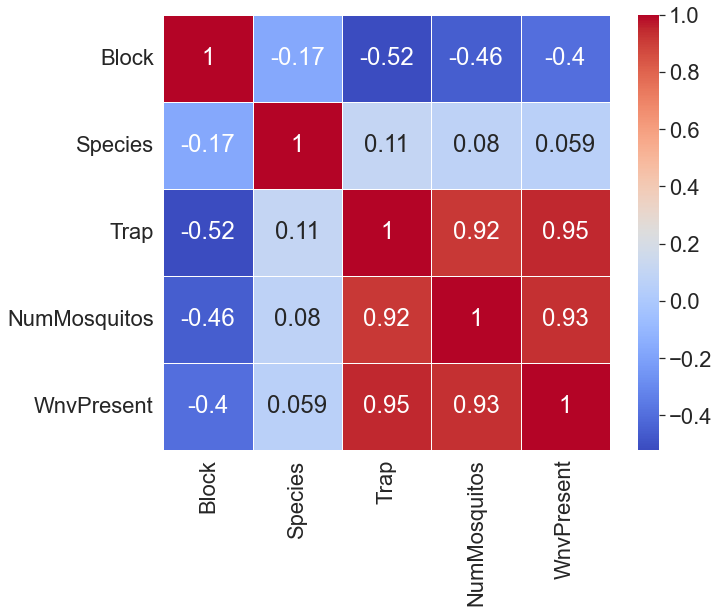

In [14]:
plt.figure(figsize=(10,8))
sns.heatmap(block_species_mos_count.corr(), linewidths=1, annot=True, cmap="coolwarm")

<AxesSubplot:>

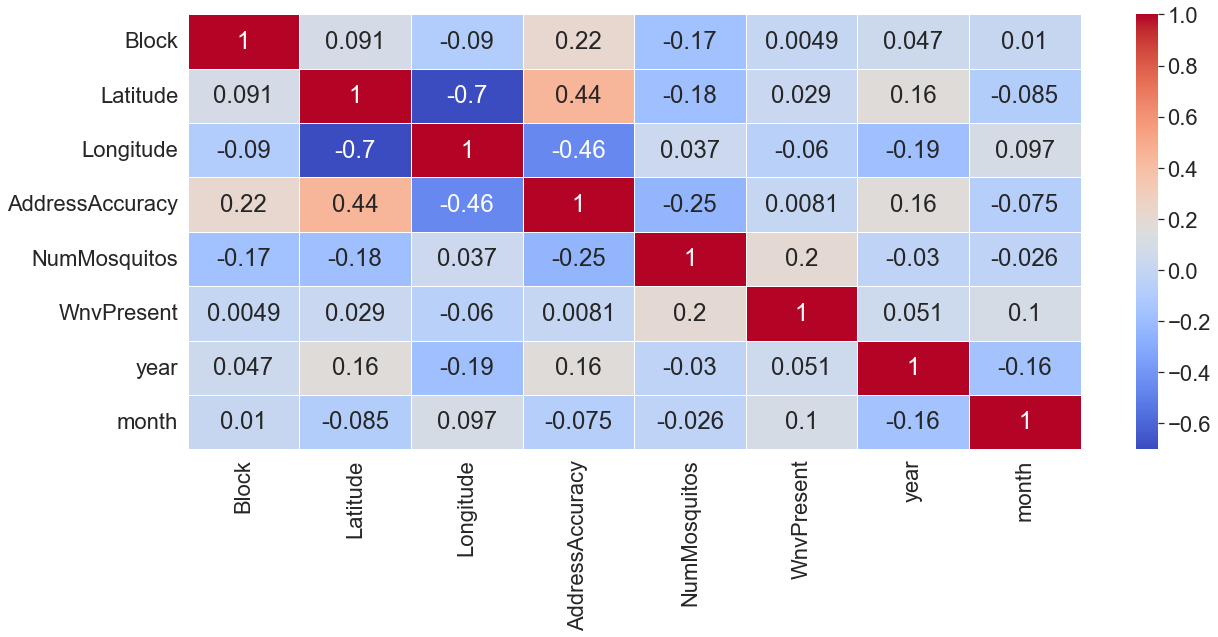

In [15]:
plt.figure(figsize=(20,8))
sns.heatmap(wnv_raw_train.corr(), linewidths=1, annot=True, cmap="coolwarm")

In [16]:
years = sorted(wnv_raw_train["year"].unique())
print (years)

[2007, 2009, 2011, 2013]


In [17]:
wnv_raw_train.isnull().any()

Date                      False
Address                   False
Species                   False
Block                     False
Street                    False
Trap                      False
AddressNumberAndStreet    False
Latitude                  False
Longitude                 False
AddressAccuracy           False
NumMosquitos              False
WnvPresent                False
year-mm                   False
year                      False
month                     False
zip_code                   True
dtype: bool

Zip Code have null values. Let's explore it.

In [18]:
wnv_raw_train[wnv_raw_train["zip_code"].isnull()].head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,year-mm,year,month,zip_code
58,2007-06-05,"South Vincennes Avenue, Chicago, IL, USA",CULEX RESTUANS,10,S VINCENNES,T089,"1000 S VINCENNES, Chicago, IL",41.723195,-87.649970,5,1,0,2007-06,2007,6,NaN
69,2007-06-05,"Chicago, IL, USA",CULEX RESTUANS,43,N ASHLAND AVE OVERPASS,T145,"4300 N ASHLAND AVE OVERPASS, Chicago, IL",41.878114,-87.629798,3,3,0,2007-06,2007,6,NaN
127,2007-06-26,"Chicago, IL, USA",CULEX RESTUANS,43,N ASHLAND AVE OVERPASS,T145,"4300 N ASHLAND AVE OVERPASS, Chicago, IL",41.878114,-87.629798,3,1,0,2007-06,2007,6,NaN
172,2007-06-29,"South Vincennes Avenue, Chicago, IL, USA",CULEX RESTUANS,10,S VINCENNES,T089,"1000 S VINCENNES, Chicago, IL",41.723195,-87.649970,5,2,0,2007-06,2007,6,NaN
179,2007-06-29,"Chicago, IL, USA",CULEX RESTUANS,43,N ASHLAND AVE OVERPASS,T145,"4300 N ASHLAND AVE OVERPASS, Chicago, IL",41.878114,-87.629798,3,1,0,2007-06,2007,6,NaN


In [19]:
def get_zipcode(df, geolocator, lat_field, lon_field):
    location = geolocator.reverse((df[lat_field], df[lon_field]))
    return location.raw['address']['postcode']

In [20]:
geolocator = geopy.Nominatim(user_agent='user_agent')

In [21]:
%%time
zipcodes = wnv_raw_train[wnv_raw_train["zip_code"].isnull()].apply(get_zipcode, axis=1, geolocator=geolocator, lat_field='Latitude', lon_field='Longitude')

In [ ]:
zipcodes.to_csv("../output/missing_zip_codes.csv")

In [ ]:
zipcodes.columns = "zip_code"

In [ ]:
wnv_raw_train=wnv_raw_train.merge(zipcodes.rename("zipcodes"), how="left", left_index=True , right_index=True)

In [ ]:
wnv_raw_train["zip_code"].fillna(wnv_raw_train["zipcodes"], inplace=True)

Now we can drop the derived zipcodes column.

In [ ]:
wnv_raw_train.drop(columns=["zipcodes"], inplace=True)

In [ ]:
#shape path:
shp_path = "../maps/Boundaries_ZIP Codes/geo_export_cdb0292c-9556-4a83-aafd-c9525a4462e3.shp"

In [ ]:
# Visualize the cities.
street_map = gpd.read_file(shp_path)

In [ ]:

# designate coordinate system
crs = {"init":"epsg:3857"}

# zip x and y coordinates into single feature
geometry = [Point(xy) for xy in zip(wnv_raw_train["Longitude"], wnv_raw_train["Latitude"])]
# create GeoPandas dataframe
geo_df = gpd.GeoDataFrame(wnv_raw_train, crs = crs, geometry = geometry)

geo_df.head()

In [ ]:
# create figure and axes, assign to subplot
fig, ax = plt.subplots(figsize=(25,25))
# add .shp mapfile to axes
street_map.plot(ax=ax, alpha=0.4)
# add geodataframe to axes
geo_df.plot(column="WnvPresent",ax=ax,alpha=0.1, legend=True,markersize="NumMosquitos", cmap="rainbow", legend_kwds={'shrink': 0.3})

geo_df.plot(column="zip_code",ax=ax,alpha=0.1, markersize="NumMosquitos", cmap="rainbow", legend = True)
# add title to graph
plt.title("West Nile Virus - Chicago City", fontsize=15,fontweight="bold")

# show map
plt.show()

In [ ]:
# read shape file
shp_data = shp.Reader(shp_path)
len(shp_data.shapes())

In [ ]:
shp_data.records()[0]

In [ ]:
# convert the shape file to dataframe
def read_shapefile(sf):
    #fetching the headings from the shape file
    fields = [x[0] for x in sf.fields][1:]
#fetching the records from the shape file
    records = [list(i) for i in sf.records()]
    shps = [s.points for s in sf.shapes()]
#converting shapefile data into pandas dataframe
    df = pd.DataFrame(columns=fields, data=records)
#assigning the coordinates
    df = df.assign(coords=shps)
    return df

In [ ]:
df = read_shapefile(shp_data)
df.head()

In [ ]:
def plot_map(sf, x_lim = None, y_lim = None, figsize = (25,15)):
    plt.figure(figsize = figsize)
    id=0
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x, y, 'k')

        if (x_lim == None) & (y_lim == None):
            x0 = np.mean(x)
            y0 = np.mean(y)
            plt.text(x0, y0, id, fontsize=10)
        id = id+1

    if (x_lim != None) & (y_lim != None):
        plt.xlim(x_lim)
        plt.ylim(y_lim)

In [ ]:
plot_map(shp_data)

### Analyze Weather dataset.

In [ ]:
wnv_raw_weather.shape

In [ ]:
wnv_raw_weather.info()

In [ ]:
wnv_raw_weather.Station.unique()

In [ ]:
wnv_raw_weather.StnPressure.unique()

TAvg has a Missing Value - M. We can impute the average value from Tmax and Tmin.

Depart, WetBulb,Heat,Cool, Depth, Water1 (all missing), SnowFall, PrecipTotal,  also has missing Value - M.
Sunrise, Sunset - missing value  "-"

In [ ]:
# strip the leading and trailing spaces.
for col in wnv_raw_weather.select_dtypes(include="object"):
    if wnv_raw_weather[wnv_raw_weather[col].str.strip()== 'T'].any().sum() > 0:
        print (col, ':', wnv_raw_weather[wnv_raw_weather[col].str.strip()== 'T'].any().sum())
        wnv_raw_weather[col] = wnv_raw_weather[col].str.strip()
        print (col, ':', wnv_raw_weather[wnv_raw_weather[col] == 'T'].any().sum())

In [ ]:
# replace the missing values with NAN
wnv_raw_weather.replace({"M":np.nan, "-":np.nan, "T": np.nan}, inplace=True)

In [ ]:
# Water1 column is totally blank. We can drop this column.
wnv_raw_weather.drop(columns=["Water1"], axis=1, inplace=True)

## Observations and next steps:

1. Water1 column is totally blank. We can drop this column.
2. Need to replace the missing value's symbolic representation to NAN.
3. Convert the data type of the columns to Numeric.
4. Impute the missing Value.


In [ ]:
# check if there are still columns with "M"
wnv_raw_weather["StnPressure"].isnull().any().sum()

In [ ]:
total_rows = wnv_raw_weather.shape[0]
column_list_null_value = wnv_raw_weather.columns[wnv_raw_weather.isnull().any()].to_list()
print (column_list_null_value)

In [ ]:
# impute missing value for Tavg
temp =  wnv_raw_weather[["Tmin","Tmax", "Tavg"]]
temp_tavg_computed = temp.T.fillna(np.ceil(temp.mean(axis=1))).T.copy()
temp_tavg_computed.head(10)
wnv_raw_weather["Tavg"] = temp_tavg_computed["Tavg"]

# check if the original dataset has missing values
print ("Missing values in Tavg = ", wnv_raw_weather["Tavg"].isnull().any().sum())

In [ ]:
wnv_raw_weather.head()
print (wnv_raw_weather.columns)

In [ ]:
wnv_raw_weather.groupby(["Station"])[["Depart", "DewPoint", "WetBulb"]].count()

In [ ]:
wnv_raw_weather.fillna(method = "ffill", inplace=True)
# check again.
col_list = [col for col in wnv_raw_weather.columns if col != "Station"]
wnv_raw_weather.groupby(["Station"])[col_list].count()

In [ ]:
wnv_raw_weather.head()

In [ ]:
# update the data type for each columns.
weather = wnv_raw_weather.astype({ "Tavg":"int64", "WetBulb":"int64"
                           , "Heat":"int64", "Cool":"int64", "ResultDir":"int64", "Depth":"int64"
                           ,  "StnPressure":"float64"
                           , "PrecipTotal":"float64","SnowFall":"float64"
                           , "SeaLevel":"float64"
                           , "ResultSpeed":"float64"
                           , "AvgSpeed":"float64"
                           , "Date":"datetime64[ns]"
                        }, copy=True)

We can drop sunrise and sunset from our weather dataset.
Also, we need to add the location specific information to <b>"weather" and "train"</b> dataset.
Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

In [ ]:
weather["Latitude"] = np.nan
weather["Longitude"] = np.nan
weather["Latitude"][weather["Station"]==1] = 41.995
weather["Latitude"][weather["Station"]==2] = 41.786
weather["Longitude"][weather["Station"]==1] = -87.933
weather["Longitude"][weather["Station"]==2] = -87.752
weather.info()

In [ ]:
train = wnv_raw_train.copy(deep=True)

In [ ]:
train["Stn1-Lat"] = 41.995
train["Stn2-Lat"] = 41.786
train["Stn1-Long"] = -87.933
train["Stn2-Long"] = -87.752
train.info()

In [ ]:
print ('Duplicates in train : ', train.duplicated().any().sum())
print ('Duplicates in weather : ', weather.duplicated().any().sum())

In [ ]:
stn1_coord = pd.Series(zip(train["Stn1-Lat"], train["Stn1-Long"])).unique()
stn2_coord = pd.Series(zip(train["Stn2-Lat"], train["Stn2-Long"])).unique()

print (stn1_coord, stn2_coord)

In [ ]:
def get_distance_stn(row, stn_coord) :
    loc1 = (row["Latitude"], row["Longitude"])
    loc2 = stn_coord
    return round(distance.distance(loc1, loc2).miles, 2)

In [ ]:
def get_closer_stn(row):
    if row["distance_frm_stn1"] <= row["distance_frm_stn2"]:
        return 1
    else:
        return 2

In [ ]:
train["distance_frm_stn1"] = train.apply(get_distance_stn, args=(stn1_coord,) ,axis=1)
train["distance_frm_stn2"] = train.apply(get_distance_stn, args=(stn2_coord,) ,axis=1)
train["closest_station"] = train[["distance_frm_stn1", "distance_frm_stn2"]].apply(get_closer_stn, axis = 1)

In [ ]:
train.head()

In [ ]:
train.groupby("closest_station")["Date"].count()

In [ ]:
weather.groupby("Station")["Date"].count()

In [ ]:
train_weather = train.merge(right=weather, how="inner", left_on=["closest_station", "Date"], right_on=["Station", "Date"], copy=True)
train_weather.head()

In [ ]:
train_weather.shape

In [ ]:
train_weather.describe().T

In [ ]:
train_weather.drop(columns=["Latitude_y", "Longitude_y"], inplace=True)

In [ ]:
train_weather.isnull().any()

In [ ]:
train_weather.to_csv("../output/train_weather.csv")
# weather.to_csv("../output/weather.csv")